*Assumptions* - Ensure your runtime meets the following if you are running on Google Colab

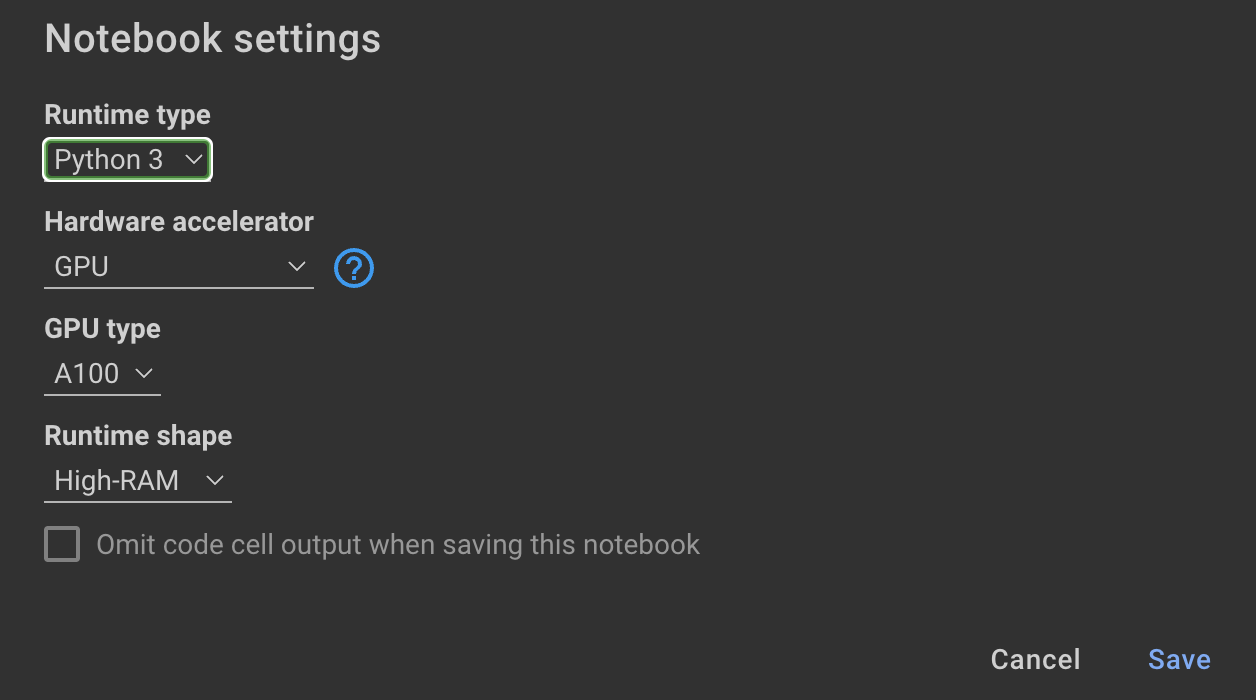

## Install requirements
First, run the cells below to install the requirements:

In [1]:
!pip install -q bitsandbytes datasets accelerate loralib 
!pip install transformers
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/accelerate.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━

## Model loading
Let's load the bloomz-3B model!

We're also going to load the bigscience/bloomz-3b which is the tokenizer for all of the BLOOM models.

This step will take some time, as we have to download the model weights which are >6GB.

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloomz-3b", 
    torch_dtype=torch.float16,
    load_in_8bit=True, 
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-3b")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('8013'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

## Model Architecture
It's important to observe the model's construction so you can ensure you know which modules you should apply LoRA to.

As per the paper, we're going to focus on the attention weights - so keep an eye out for modules like: q_proj, v_proj, query_key_value. This is model dependent.

In [4]:
print(model)

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 2560)
    (word_embeddings_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-29): 30 x BloomBlock(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear8bitLt(in_features=2560, out_features=7680, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2560,), eps=1e-05, elemen

## Post-processing on the model
Finally, we need to apply some post-processing on the 8-bit model to enable training, let's freeze all our layers, and cast the layer-norm in float32 for stability. We also cast the output of the last layer in float32 for the same reasons.

In [5]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

## Apply LoRA
Here comes the magic with peft! Let's load a PeftModel and specify that we are going to use low-rank adapters (LoRA) using get_peft_model utility function from peft.

## Helper Function to Print Parameter %age
This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [6]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

## Initializing LoRA Config
There's a lot to unpack here - so let's talk about the main parameters:

`r:` is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

`target_modules: `As LoRA can be applied to any weight matrix - we need to configure which module (weight matrix) it's being applied to. The paper suggests applying it to the Attention weights, and so we're doing that here. Be mindful that, while BLOOMZ's attention weight modules are called query_key_value - other models will name them with different convention. Please ensure you look at your model's architecture and select the appropriate module.

`task_type:` This is a derived property. If you're using a causal model, this should be set to CAUSAL_LM. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification](https://huggingface.co/docs/peft/task_guides/token-classification-lora)!

In [7]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 4915200 || all params: 3007472640 || trainable%: 0.1634329082375293


## Preprocessing
We can simply load our dataset from 🤗 Hugging Face with the load_dataset method!

In [9]:
import transformers
from datasets import load_dataset

HUGGING_FACE_USER_NAME = "lgfunderburk"
dataset_name = "numpy-docs"
dataset_name = f"{HUGGING_FACE_USER_NAME}/{dataset_name}"
product_name = "product"
product_desc = "description"
product_ad = "automating_tech_blog"

In [10]:
dataset = load_dataset(dataset_name)
print(dataset)
print(dataset['train'][0])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/lgfunderburk___parquet/lgfunderburk--numpy-docs-fd4e23ca7a82b890/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'summary', 'social_media_post'],
        num_rows: 13
    })
})
{'id': 1, 'summary': 'In this tutorial, the author demonstrates how to use Singular Value Decomposition (SVD) – a matrix decomposition from linear algebra – to generate a compressed approximation of an image using NumPy. The tutorial explains the difference between dimensions and axes in NumPy, how to extract data from an image, and how to perform linear algebra operations on the RGB channels of the image. By applying SVD to the image, the author shows how to reconstruct both the full and approximated image, which highlights how well an image can be represented using fewer singular values. The tutorial is useful for those who want to understand image compression and related linear algebra concepts using Python and NumPy.', 'social_media_post': ''}


Because we're using BLOOMZ (which is an instruct-tuned base model), we should see better results providing the instruction - though that is not necessary.

In [11]:
def generate_prompt(summary: str, social_media_post: str) -> str:
  prompt = f"### INSTRUCTION\nBelow is a summary of a post\
           and its corresponding social media post, please \
           write social media post for this blog.\
           \n\n### Summary:\n{summary}\n### Post:\n{social_media_post}\n"
  return prompt

mapped_dataset_2 = dataset.map(lambda samples: tokenizer(generate_prompt(samples['summary'], samples['social_media_post'])))


Map:   0%|          | 0/13 [00:00<?, ? examples/s]

The Trainer class contains all the usual suspects - these are the same hyper-parameters you know and love from traditional ML applications!

If you're running into CUDA memory issues - please modify both the per_device_train_batch_size to be lower, and also reduce r in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [12]:
trainer = transformers.Trainer(
    model=model, 
    train_dataset=mapped_dataset_2["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=6, 
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=100, 
        learning_rate=1e-3, 
        fp16=True,
        logging_steps=1, 
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,2.358200
2,0.888100
3,1.470300
4,1.581500
5,0.714800
6,2.238700
7,2.215900
8,0.806200
9,1.454200
10,1.486600


TrainOutput(global_step=100, training_loss=0.5036547118285671, metrics={'train_runtime': 232.3935, 'train_samples_per_second': 10.327, 'train_steps_per_second': 0.43, 'total_flos': 4445402306641920.0, 'train_loss': 0.5036547118285671, 'epoch': 66.67})

## Share adapters on the 🤗 Hub
Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first merge_and_unload() the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

Please note that if you leveraged bitsandbytes to load the model in 8-bit - you cannot merge the weights into the base model at this step.

In [13]:
from huggingface_hub import notebook_login
notebook_login()

In [14]:
model_name = "numpy-social-media-post"

model.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)


Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/lgfunderburk/numpy-social-media-post/commit/1632b183587edbb9d8359457092d5d8a028d4d60', commit_message='Upload model', commit_description='', oid='1632b183587edbb9d8359457092d5d8a028d4d60', pr_url=None, pr_revision=None, pr_num=None)